<a href="https://colab.research.google.com/github/Myavuzars/MachineLearning/blob/main/Imbalanced_Data__2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

In [62]:
import warnings
warnings.filterwarnings('ignore')

In [63]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [64]:
df = pd.read_csv(
    "/content/drive/MyDrive/Colab Notebooks/Machine Learning /Customer-Churn.csv")

df.head(4)

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No


In [65]:
df.shape

(7043, 21)

In [66]:
df['Churn'].value_counts()

No     5174
Yes    1869
Name: Churn, dtype: int64

In [67]:
df.nunique()

customerID          7043
gender                 2
SeniorCitizen          2
Partner                2
Dependents             2
tenure                73
PhoneService           2
MultipleLines          3
InternetService        3
OnlineSecurity         3
OnlineBackup           3
DeviceProtection       3
TechSupport            3
StreamingTV            3
StreamingMovies        3
Contract               3
PaperlessBilling       2
PaymentMethod          4
MonthlyCharges      1585
TotalCharges        6531
Churn                  2
dtype: int64

In [68]:
df.drop(['customerID'], axis=1, inplace=True)

In [69]:
df.dtypes

gender               object
SeniorCitizen         int64
Partner              object
Dependents           object
tenure                int64
PhoneService         object
MultipleLines        object
InternetService      object
OnlineSecurity       object
OnlineBackup         object
DeviceProtection     object
TechSupport          object
StreamingTV          object
StreamingMovies      object
Contract             object
PaperlessBilling     object
PaymentMethod        object
MonthlyCharges      float64
TotalCharges         object
Churn                object
dtype: object

In [70]:
catdf =df.iloc[:,:-3]
numdf= df.iloc[:,-3:-1]
y= df.iloc[:,-1]
numdf.head()

,MonthlyCharges,TotalCharges
0,29.85,29.85
1,56.95,1889.5
2,53.85,108.15
3,42.30,1840.75
4,70.70,151.65


In [71]:
def convert_cat(df):
  for col in df.columns:
      df[col] = df[col].astype('category')

convert_cat(catdf)

In [72]:
numdf['TotalCharges']=numdf['TotalCharges'].str.replace(' ','0').astype('float64')

In [13]:
#df['TotalCharges']=pd.to_numeric(df['TotalCharges'])


In [73]:
#Encoding
from sklearn.preprocessing import LabelEncoder
encoder= LabelEncoder()

for col in catdf:
  catdf[col] = encoder.fit_transform(catdf[col])


In [74]:
#Encoding Target Variable
y= encoder.fit_transform(y)

In [75]:
len(catdf.columns)

17

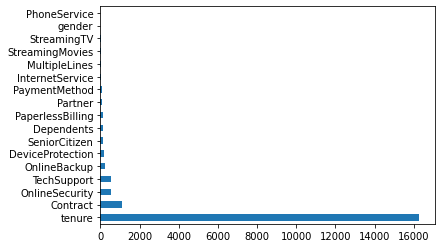

In [17]:
#Chi Square Independency Testing  
from sklearn.feature_selection import chi2
from sklearn.feature_selection import SelectKBest
k=len(catdf.columns)
test = SelectKBest(score_func=chi2, k=k) 
fit = test.fit(catdf, y)
fit.scores_

imp = pd.Series(fit.scores_, index= catdf.columns)
imp.nlargest(k).plot(kind="barh")
plt.show()

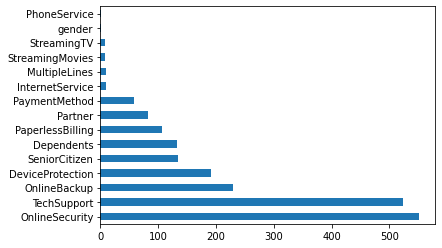

In [18]:
#Chi Square Independency Testing after removing tenure and Contract to see the better picture
cat_df =catdf.drop(['tenure', 'Contract'], axis=1)
from sklearn.feature_selection import chi2
from sklearn.feature_selection import SelectKBest
k=len(cat_df.columns)
test = SelectKBest(score_func=chi2, k=k) 
fit = test.fit(cat_df, y)
fit.scores_

imp = pd.Series(fit.scores_, index= cat_df.columns)
imp.nlargest(k).plot(kind="barh")
plt.show()

In [19]:
# It is better drop the columns that scores lower than Payment Method 

new_catdf = catdf.drop(['PhoneService', 'gender', 'StreamingTV', 'MultipleLines','InternetService'], axis=1)

In [20]:
new_catdf.head()

,SeniorCitizen,Partner,Dependents,tenure,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingMovies,Contract,PaperlessBilling,PaymentMethod
0,0,1,0,1,0,2,0,0,0,0,1,2
1,0,0,0,34,2,0,2,0,0,1,0,3
2,0,0,0,2,2,2,0,0,0,0,1,3
3,0,0,0,45,2,0,2,2,0,1,0,0
4,0,0,0,2,0,0,0,0,0,0,1,2


In [21]:
from sklearn.preprocessing import StandardScaler
scaler= StandardScaler()
numdf =scaler.fit_transform(numdf)
numdf =pd.DataFrame(numdf)

In [22]:
X = pd.concat([new_catdf,numdf], axis=1 )
X.head()

,SeniorCitizen,Partner,Dependents,tenure,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,0,1
0,0,1,0,1,0,2,0,0,0,0,1,2,-1.160323,-0.992611
1,0,0,0,34,2,0,2,0,0,1,0,3,-0.259629,-0.172165
2,0,0,0,2,2,2,0,0,0,0,1,3,-0.362660,-0.958066
3,0,0,0,45,2,0,2,2,0,1,0,0,-0.746535,-0.193672
4,0,0,0,2,0,0,0,0,0,0,1,2,0.197365,-0.938874


In [23]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=1)

In [32]:
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score, confusion_matrix, roc_auc_score, precision_score, recall_score, precision_recall_curve
from numpy import mean
#Model
def evaluate_model(X, y, model):
	# define evaluation procedure
	cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
	# evaluate model
	scores = cross_val_score(model, X, y, scoring='accuracy', cv=cv, n_jobs=-1)
	return scores

In [33]:
#Dummy Classifieer
from sklearn.dummy import DummyClassifier
# define the reference model
model = DummyClassifier(strategy='most_frequent')

In [34]:
# Evaluate the model
scores = evaluate_model(X, y, model)
# summarize performance
print('Mean Accuracy: %.3f'  % (mean(scores)))

Mean Accuracy: 0.735


In [35]:
#Gradient Boosting Machine (GBM)
from sklearn.ensemble import GradientBoostingClassifier
model_XGB =GradientBoostingClassifier(n_estimators=100)

In [36]:
# Evaluate the model
scores = evaluate_model(X, y, model_XGB)
# summarize performance
print('Mean Accuracy: %.3f'  % (mean(scores)))

Mean Accuracy: 0.801


In [40]:
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import GridSearchCV
import numpy as np
parameters = {
    'max_depth': [3, 6],
    'n_estimators': [10, 100],
    'learning_rate': [0.1, 0.01, 0.05]
}
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
classifier = GridSearchCV(estimator=model_XGB, cv=cv, param_grid=parameters)
classifier.fit(X_train, y_train)

GridSearchCV(cv=RepeatedStratifiedKFold(n_repeats=3, n_splits=10, random_state=1),
             estimator=GradientBoostingClassifier(),
             param_grid={'learning_rate': [0.1, 0.01, 0.05],
                         'max_depth': [3, 6], 'n_estimators': [10, 100]})

In [41]:
#Final evaluation on the test set
classifier.score(X_test, y_test)

0.8069278818852924

In [42]:
#SMOTE Technique
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline

over = SMOTE()
under = RandomUnderSampler(sampling_strategy=0.4)

In [43]:
# transform the dataset
X, y = over.fit_resample(X, y)

In [44]:
# Evaluate the model for Dummy Classifier
scores = evaluate_model(X, y, model)
# summarize performance
print('Mean Accuracy: %.3f'  % (mean(scores)))

Mean Accuracy: 0.500


In [45]:
# Evaluate the model
scores = evaluate_model(X, y, model_XGB)
# summarize performance
print('Mean Accuracy: %.3f'  % (mean(scores)))

Mean Accuracy: 0.808


In [ ]:
###

In [46]:
from sklearn.metrics import accuracy_score, confusion_matrix, roc_auc_score, precision_score, recall_score, precision_recall_curve

In [47]:
from imblearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
from sklearn.svm import LinearSVC

model = make_pipeline(
    StandardScaler(),
    SMOTE(random_state=10),
    LinearSVC(max_iter=10_000, random_state=1),
)

In [48]:
model.fit(X, y)


Pipeline(steps=[('standardscaler', StandardScaler()),
                ('smote', SMOTE(random_state=10)),
                ('linearsvc', LinearSVC(max_iter=10000, random_state=1))])

In [49]:
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

In [50]:
from imblearn.metrics import geometric_mean_score
# The geometric mean corresponds to the square root of the product of the sensitivity and specificity. 
# Combining the two metrics should account for the balancing of the dataset.

print(f"The geometric mean is {geometric_mean_score(y_test, y_pred):.3f}")

The geometric mean is 0.757


In [51]:
print(f'Recall Score: \n {recall_score(y_test, y_pred)}')

Recall Score: 
 0.7944325481798715


In [52]:
# Test the models
print(f"The score is {model.score(X_test, y_test):.3f}")

The score is 0.740


In [55]:
#####
#Weighted Logistic Regression

In [56]:
from sklearn.linear_model import LogisticRegression

In [57]:
X.head()

,SeniorCitizen,Partner,Dependents,tenure,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,0,1
0,0,1,0,1,0,2,0,0,0,0,1,2,-1.160323,-0.992611
1,0,0,0,34,2,0,2,0,0,1,0,3,-0.259629,-0.172165
2,0,0,0,2,2,2,0,0,0,0,1,3,-0.362660,-0.958066
3,0,0,0,45,2,0,2,2,0,1,0,0,-0.746535,-0.193672
4,0,0,0,2,0,0,0,0,0,0,1,2,0.197365,-0.938874


In [58]:
#Simple Logistic Regression
lg1 = LogisticRegression(random_state=1, class_weight=None)
lg1.fit(X_train, y_train)
y_pred = lg1.predict(X_test)

print(f'Confusion Matrix:\n {confusion_matrix(y_test, y_pred)}')
print()
print(f'Recall Score:  {recall_score(y_test, y_pred)}')

Confusion Matrix:
 [[1166  128]
 [ 216  251]]

Recall Score:  0.5374732334047109


In [59]:
#Balanced Logistic Regression
lg2 = LogisticRegression(random_state=1, class_weight='balanced')
lg2.fit(X_train, y_train)
y_pred2 = lg2.predict(X_test)

print(f'Confusion Matrix:\n {confusion_matrix(y_test, y_pred2)}')
print()
print(f'Recall Score: {recall_score(y_test, y_pred2)}')

Confusion Matrix:
 [[925 369]
 [ 93 374]]

Recall Score: 0.8008565310492506


Fitting 5 folds for each of 200 candidates, totalling 1000 fits


Text(0.5, 1.0, 'Scoring for different class weights')

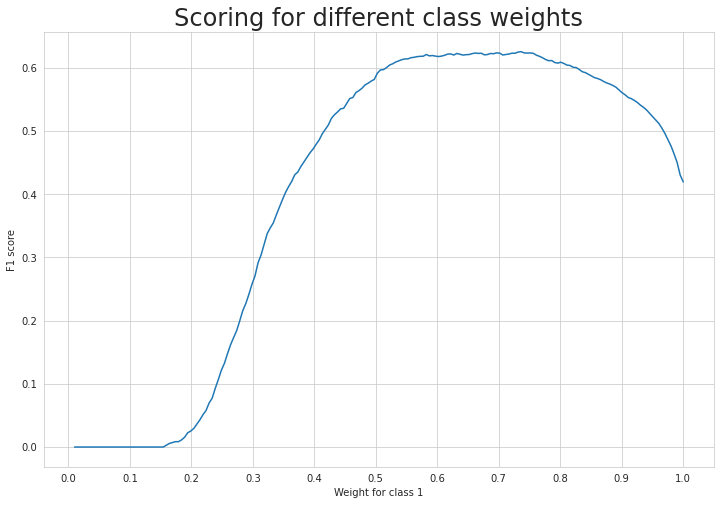

In [60]:
#Weighted Logistic Regression

#Choosing the weight
from sklearn.model_selection import GridSearchCV, StratifiedKFold
lr = LogisticRegression(solver='newton-cg')

#Setting the range for class weights
weights = np.linspace(0.0,0.99,200)

#Creating a dictionary grid for grid search
param_grid = {'class_weight': [{0:x, 1:1.0-x} for x in weights]}

#Fitting grid search to the train data with 5 folds
gridsearch = GridSearchCV(estimator= lr, 
                          param_grid= param_grid,
                          cv=StratifiedKFold(), 
                          n_jobs=-1, 
                          scoring='f1', 
                          verbose=2).fit(X_train, y_train)

#Ploting the score for different values of weight
sns.set_style('whitegrid')
plt.figure(figsize=(12,8))
weigh_data = pd.DataFrame({ 'score': gridsearch.cv_results_['mean_test_score'], 'weight': (1- weights)})
sns.lineplot(weigh_data['weight'], weigh_data['score'])
plt.xlabel('Weight for class 1')
plt.ylabel('F1 score')
plt.xticks([round(i/10,1) for i in range(0,11,1)])
plt.title('Scoring for different class weights', fontsize=24)




In [61]:
lg3 = LogisticRegression(solver='newton-cg', class_weight={0: 0.27, 1: 0.73})
lg3.fit(X_train, y_train)
y_pred3 = lg3.predict(X_test)

print(f'Confusion Matrix:\n {confusion_matrix(y_test, y_pred3)}')
print()
print(f'Recall Score: {recall_score(y_test, y_pred3)}')

Confusion Matrix:
 [[933 361]
 [ 96 371]]

Recall Score: 0.7944325481798715
